In [2]:
import numpy as np
from tiatoolbox.wsicore.wsireader import VirtualWSIReader, WSIReader
import os
import matplotlib.pyplot as plt
import cv2
from utils import mm2_to_px, dist_to_px, get_tumor_stroma_mask, slide_nms
import skimage
from PIL import Image
import shutil
import json
from tiatoolbox.annotation.storage import Annotation, SQLiteStore
from shapely import Point, Polygon, box

|2024-05-30|18:00:31.595| [WARNING] /home/u1910100/miniconda3/envs/tiatoolbox/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()

|2024-05-30|18:00:31.596| [WARNING] /home/u1910100/miniconda3/envs/tiatoolbox/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details

In [ ]:
torch_seg_out_path = "output/seg_out"
tf_seg_out_path = "tf_seg_out/tempout"

wsi_dir = "/home/u1910100/Documents/Tiger_Data/wsitils/images"
total = 0

for image in os.listdir(wsi_dir):
    wsi_name = os.path.splitext(image)[0]
    tf_bulk_path = os.path.join(tf_seg_out_path, f"{wsi_name}_bulk.npy")
    if not os.path.exists(tf_bulk_path):
        print(f"{tf_bulk_path} does not exist")
        continue
    fig, axes = plt.subplots(2, 2)
    tf_bulk_mask = np.load(tf_bulk_path)
    wsi_path = os.path.join(wsi_dir, f"{wsi_name}.tif")

    wsi_reader = WSIReader.open(wsi_path)
    thumb = wsi_reader.slide_thumbnail(resolution=0.3125, units="power")

    # stroma_path = os.path.join(seg_out_path, f"{wsi_name}_stroma.npy")
    tumor_path = os.path.join(tf_seg_out_path, f"{wsi_name}_bulk_tumor.npy")
    tumor_mask = np.load(tumor_path)
    stroma_path = os.path.join(tf_seg_out_path, f"{wsi_name}_bulk_stroma.npy")
    stroma_mask = np.load(stroma_path)

    axes[0, 0].imshow(thumb)
    axes[0, 0].title.set_text(wsi_name)
    axes[0, 0].axis("off")
    axes[0, 1].imshow(tf_bulk_mask)
    axes[0, 1].title.set_text("bulk mask")
    axes[0, 1].axis("off")
    axes[1, 0].imshow(stroma_mask)
    axes[1, 0].title.set_text("bulk stroma")
    axes[1, 0].axis("off")
    axes[1, 1].imshow(tumor_mask)
    axes[1, 1].title.set_text("bulk tumor")
    axes[1, 1].axis("off")
    plt.show()
    save_path = os.path.join(eval_dir, f"{wsi_name}.png")
    fig.savefig(
        save_path,
        bbox_inches="tight",
        pad_inches=0,
    )
    fig.clf()
    plt.close()

    total += 1

print(total)

In [29]:
torch_seg_out_path = "output/seg_out"
wsi_dir = "/home/u1910100/Documents/Tiger_Data/wsitils/images"
overlay = "/home/u1910100/Documents/Tiger_out_vis/overlays"

In [27]:
mask_path = "/home/u1910100/Documents/Tiger_Data/testinput/images/104S_tissue.tif"
mask_reader = WSIReader.open(mask_path)
# mask = mask_reader.slide_thumbnail(resolution=1.25, units="power")[:, :, 0]
# mask = (mask * 255).astype('uint8')
# heatmap_img = Image.fromarray(mask)
# heatmap_img.save(os.path.join(overlay, f"104S.png"))

|2024-05-30|16:59:20.095| [WARNING] Metadata: Falling back to TIFF resolution tag for microns-per-pixel (MPP).
|2024-05-30|16:59:20.096| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


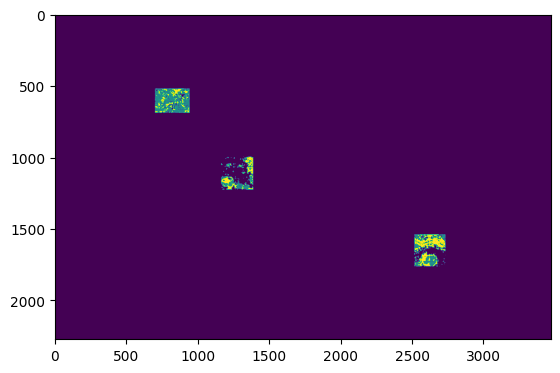

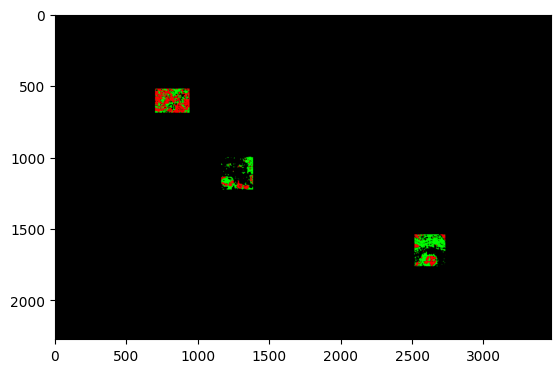

In [20]:
mask_path = "/home/u1910100/Documents/Tiger_Data/output/images/breast-cancer-segmentation-for-tils/segmentation.tif"
mask_reader = WSIReader.open(mask_path)
mask = mask_reader.slide_thumbnail(resolution=1.25, units="power")[:, :, 0]
plt.imshow(mask)
plt.show()

heatmap = np.zeros(shape=(mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
heatmap[:, :, 0] = np.where(mask == 1, 255, 0)
heatmap[:, :, 1] = np.where(mask == 2, 255, 0)

plt.imshow(heatmap)
plt.show()

heatmap_img = Image.fromarray(heatmap)
heatmap_img.save(os.path.join(overlay, f"104S_tissue.png"))

In [ ]:
names = [
    "105S",
    "123S",
    "248B",
    "TC_S01_P000052_C0001_B101",
    "TC_S01_P000124_C0001_B101",
]

for name in names:
    tumor_mask = np.load(os.path.join(torch_seg_out_path, f"{name}_tumor.npy"))
    stroma_mask = np.load(os.path.join(torch_seg_out_path, f"{name}_stroma.npy"))
    stroma_bulk = np.load(os.path.join(torch_seg_out_path, f"{name}_stroma_bulk.npy"))

    heatmap = np.zeros(
        shape=(tumor_mask.shape[0], tumor_mask.shape[1], 3), dtype=np.uint8
    )
    heatmap[:, :, 0] = np.where(stroma_bulk == 1, 255, 0)
    heatmap[:, :, 1] = np.where(tumor_mask == 1, 255, 0)
    heatmap[:, :, 2] = np.where(stroma_mask == 1, 255, 0)

    plt.imshow(heatmap)
    plt.show()

    heatmap_img = Image.fromarray(heatmap)
    heatmap_img.save(os.path.join(overlay, f"{name}.png"))

    # shutil.copyfile(f"{wsi_dir}/{name}.tif", os.path.join(overlay, f"{name}.tiff"))

In [28]:
def points_to_annotation_store(points: list):
    """
    Args: points(list): list of (x,y) coordinates
    """
    annotation_store = SQLiteStore()

    for coord in points:
        annotation_store.append(
            Annotation(
                geometry=Polygon.from_bounds(
                    coord[0] - 8, coord[1] - 8, coord[0] + 8, coord[1] + 8
                ),
                properties={"class": 1, "type": "TIL"},
            )
            # Annotation(geometry=Point(coord[0], coord[1]), properties={"class": 1, "type": "TIL"})
        )

    return annotation_store

In [30]:
wsi_without_ext = "104S"
cell_points_dir = "/home/u1910100/Documents/Tiger_Data/tempoutput"
cell_points_path = os.path.join(cell_points_dir, f"{wsi_without_ext}_points.json")

with open(cell_points_path, "r") as fp:
    cell_points = json.load(fp)

# nms_points = slide_nms(slide_path=wsi_path, cell_points=cell_points, tile_size=2048)
print(len(cell_points))
store = points_to_annotation_store(cell_points)
store.dump(os.path.join(overlay, f"{wsi_without_ext}.db"))

2321


In [6]:
from wholeslidedata import WholeSlideImage
from wholeslidedata.interoperability.openslide.backend import (
    OpenSlideWholeSlideImageBackend,
)

import numpy as np

from matplotlib import pyplot as plt

plt.rc("font", size=12)

path = "/home/u1910100/Documents/Tiger_Data/output/images/breast-cancer-segmentation-for-tils/segmentation.tif"

wsi = WholeSlideImage(path, backend=OpenSlideWholeSlideImageBackend)


print(f"wsi path: {wsi.path}")
print(f"level count: {wsi.level_count}")
print(f"spacings: {wsi.spacings}")
print(f"shapes:  {wsi.shapes}")
print(f"downsamplings: {wsi.downsamplings}")


wsi_reader = WSIReader.open(path)
print(wsi_reader.info.as_dict())

|2024-05-30|18:02:22.067| [WARNING] Metadata: Falling back to TIFF resolution tag for microns-per-pixel (MPP).
|2024-05-30|18:02:22.067| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


wsi path: /home/u1910100/Documents/Tiger_Data/output/images/breast-cancer-segmentation-for-tils/segmentation.tif
level count: 8
spacings: [0.45669399219053275, 0.9133879843810655, 1.826775968762131, 3.653551937524262, 7.307103875048524, 14.614207750097048, 29.228415500194096, 58.45683100038819]
shapes:  ((55552, 36352), (27776, 18176), (13888, 9088), (6944, 4544), (3472, 2272), (1736, 1136), (868, 568), (434, 284))
downsamplings: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)
{'objective_power': 20.0, 'slide_dimensions': (55552, 36352), 'level_count': 8, 'level_dimensions': ((55552, 36352), (27776, 18176), (13888, 9088), (6944, 4544), (3472, 2272), (1736, 1136), (868, 568), (434, 284)), 'level_downsamples': [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0], 'vendor': 'generic-tiff', 'mpp': (0.45669399219053275, 0.45669399219053275), 'file_path': PosixPath('/home/u1910100/Documents/Tiger_Data/output/images/breast-cancer-segmentation-for-tils/segmentation.tif'), 'axes': 'YXS'}
